In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import os

from utils import *
from plot_utils import *
from AnalyseDefects_dev import AnalyseDefects
from AnalyseDefectsAll import AnalyseDefectsAll

plt.rcParams.update({"text.usetex": True})

In [2]:

# STEP 1: Initialize the analysis parameters and data paths
##### ---------------------------------------------------

data_suffix='lk' #'lambda_minus1'
LL = 512
mode = 'all' # 'all' or 'short'

extract = False
do_basic_analysis = False
do_hyperuniformity_analysis = False
do_merge = False
calc_pcf = False


if data_suffix == 'lk':
    prefix_list = []
    suffix_list = ['025', '10']
    Nframes_list = [400, 400] 
    count_suffix = "_periodic_rm0.1"
    label_list = [r'$K = 0.025$', 
                r'$K = 0.05$',
                r'$K = 0.1$']
elif data_suffix == 'lbc':
    prefix_list = []
    suffix_list = ['3', '4']
    Nframes_list = [400, 400] 
    count_suffix = "_rm0.1"
    label_list = ['free-slip', 'periodic', 'no-slip']
elif data_suffix == 'lam':
    prefix_list = []
    suffix_list = ['05', '2']
    Nframes_list = [100, 100] 
    count_suffix = "_periodic_rm0.1"
    label_list = [r'$\lambda = 0.5$', 
                r'$\lambda = 1$',
            r'$\lambda = 2$']

output_path = f'data\\na{LL}{data_suffix}'
save_path = os.path.join(output_path, 'figs')
if not os.path.exists(save_path):
    os.makedirs(save_path)

defect_list = []

if len(prefix_list) > 0:
    for i, prefix in enumerate(prefix_list):
        data_dict = dict(path = f'X:\\na512exp\\na{LL}{prefix}{data_suffix}', \
                    suffix = 's' if len(prefix) == 0 else prefix, priority = i, LX = LL, Nframes = Nframes_list[i])
        defect_list.append(data_dict)
else:
    for i, suffix in enumerate(suffix_list):
        data_dict = dict(path = f'X:\\na512exp\\na{LL}{data_suffix}{suffix}', \
                    suffix = suffix, priority = 0, LX = LL, Nframes =  Nframes_list[i])
        defect_list.append(data_dict)


ad = AnalyseDefects(defect_list, output_path=output_path, count_suffix=count_suffix,)


# STEP 2: Extract data and perform analysis
##### ---------------------------------------------------

if extract:
    ad.extract_results()
if do_basic_analysis or do_hyperuniformity_analysis:
    # hyperuniformity parameters
    act_idx_bounds=[0,None]
    Npoints_to_fit = 20
    dens_fluc_dict = dict(act_idx_bounds = [0, None], window_idx_bounds = [50 - Npoints_to_fit, None])

    # sfac fitting parameters
    pval_min = 0.05
    Nbounds = [4,5]
    sfac_dict = dict(Npoints_bounds = Nbounds, act_idx_bounds = act_idx_bounds, pval_min = pval_min)

    # temporal correlation parameter
    temp_corr_simple = True
    nlags = None
    ff_idx = None
    acf_dict = {'nlags_frac': 0.5, 'nlags': nlags, 'max_lag': None,\
                    'alpha': 0.3174, 'max_lag_threshold': 0, 'simple_threshold': 0.2, \
                    'first_frame_idx': ff_idx}

    if do_basic_analysis:
        if do_hyperuniformity_analysis:
            print(' sfac n bounds:', Nbounds)
            
            ad.analyze_defects(temp_corr_simple=temp_corr_simple,
                                acf_dict=acf_dict,
                                dens_fluc_dict=dens_fluc_dict, 
                                sfac_dict=sfac_dict, 
                                calc_pcf=calc_pcf)
        else:
            ad.analyze_defects(acf_dict=acf_dict,
                                temp_corr_simple=temp_corr_simple)
if do_merge:
    ad.merge_results()

In [3]:
LL = 512
output_path_ref = f'data\\na{LL}'
mode_ref = 'all' # 'all' or 'short'

defect_list_ref = gen_analysis_dict(LL, mode_ref)
ad2 = AnalyseDefects(defect_list_ref, output_path=output_path_ref)

In [ ]:
act_list_list = [ad.act_list[0], ad2.act_list_merged, ad.act_list[1]]
marker_list = ['ro', 'bs', 'gd']


fig, ax = plt.subplots(figsize=(7,5))

K_list = [0.025, 0.05, 0.1]

K_rel_list = [.5, 1, 2]

## ASSUMPTION: Scaling relation of the form: rho(zeta,k) = k^ (-beta) * g (zeta/k^alpha),
## where g is a function of zeta/k^alpha, and beta is a scaling exponent.
## ie so that rho * k ^beta = g(zeta/k^alpha) and plotting rho * k^beta vs zeta/k^alpha should collapse graphs

av_defect_list = [ad.get_arrays_av(0)[-1], ad2.get_arrays_av(use_merged=True)[-1], ad.get_arrays_av(1)[-1]]

for i, label in enumerate(label_list):

    act_arr= np.array(act_list_list[i])

    alpha = 4/5
    beta = 1/3

    #act_active = #np.sqrt(K_list[i])**1.6# / act_arr)
  #  scaling = 1/K_list[i] #/0.05 #1/ np.sqrt(act_arr/K_list[i])
    act_scaled = act_arr / K_list[i]**alpha # np.sqrt(act_arr / K_list[i])

    #act_scaled = act_arr
    av_def = av_defect_list[i] / LL ** 2
    av_def[:,0] = av_def[:,0] * K_list[i]**beta
    av_def[:,1] = av_def[:,1] * K_list[i]**beta 

    ax.errorbar(act_scaled, av_def[:,0], av_def[:,1], fmt = marker_list[i], label=label,
                elinewidth=1.5, capsize=1.5, capthick=1, markersize = 5, alpha=.5)

ax.set_xlabel(r'Activity ($\zeta$)')
ax.set_ylabel(r' Av. defect density ($\overline{\rho})$')
#ax.vlines(x=0.022, ymin = -1e-2, ymax=.6e-2, linestyle='--', color='k', lw = 1)
#ax.hlines(y=0, xmin=0, xmax=.052, linestyle='-', color='k', lw = 1 )

#ax.xaxis.set_minor_locator(ticker.MultipleLocator(2e-3))   
#ax.yaxis.set_minor_locator(ticker.MultipleLocator(.5e-3))     
#ax.set_xlim([0, 0.052])
#ax.set_ylim(ymin=-.05e-2, ymax = .6e-2)
ax.legend(loc='upper left', ncols=1)
ax.set_xlim(xmax=.6)
ax.set_ylim(ymax=2.2e-3)

In [ ]:
act_list_list = [ad.act_list[0], ad2.act_list_merged, ad.act_list[1]]
marker_list = ['ro', 'bs', 'gd']


qc = lambda zeta, k, lam, eta, gamma: np.sqrt( (lam * zeta) / (2 * k * (2 * eta * gamma + lam ** 2)))
qs_res = lambda zeta, k: qc(zeta, k, lam=1, eta=1, gamma=0.05)


fig, ax = plt.subplots(figsize=(7,5))

K_list = [0.025, 0.05, 0.1]

## ASSUMPTION: Scaling relation of the form: rho(zeta,k) = k^ (-beta) * g (zeta/k^alpha),
## where g is a function of zeta/k^alpha, and beta is a scaling exponent.
## ie so that rho * k ^beta = g(zeta/k^alpha) and plotting rho * k^beta vs zeta/k^alpha should collapse graphs

av_defect_list = [ad.get_arrays_av(0)[-1], ad2.get_arrays_av(use_merged=True)[-1], ad.get_arrays_av(1)[-1]]

for i, label in enumerate(label_list):

    act_arr= np.array(act_list_list[i])

    alpha = -1
    beta = 3  #3/2#4/3+.1

    x_act = np.sqrt(K_list[i] / act_arr)
    x_coh = np.sqrt(K_list[i])
    x_crit = 1 / qs_res(act_arr, K_list[i])

    rho_scaling = x_crit / LL # 1 / qs_res(act_arr, K_list[i])#(K_list[i] / act_arr)
    #rho_scaling = x_coh/x_crit
   # zeta_scaling 

    #act_active = #np.sqrt(K_list[i])**1.6# / act_arr)
  #  scaling = 1/K_list[i] #/0.05 #1/ np.sqrt(act_arr/K_list[i])
    act_scaled = act_arr / K_list[i]**alpha # np.sqrt(act_arr / K_list[i])

    act_scaled = act_arr / rho_scaling**alpha
    #act_scaled = act_arr
    av_def = av_defect_list[i] #/ LL ** 2
    av_def[:,0] = av_def[:,0] * rho_scaling**beta #K_list[i]**beta
    av_def[:,1] = av_def[:,1] * rho_scaling**beta #K_list[i]**beta 

    ax.errorbar(act_scaled, av_def[:,0], av_def[:,1], fmt = marker_list[i], label=label,
                elinewidth=1.5, capsize=1.5, capthick=1, markersize = 5, alpha=.5)

ax.set_xlabel(r'Activity ($\zeta$)')
ax.set_ylabel(r' Av. defect density ($\overline{\rho})$')
#ax.vlines(x=0.022, ymin = -1e-2, ymax=.6e-2, linestyle='--', color='k', lw = 1)
#ax.hlines(y=0, xmin=0, xmax=.052, linestyle='-', color='k', lw = 1 )

#ax.xaxis.set_minor_locator(ticker.MultipleLocator(2e-3))   
#ax.yaxis.set_minor_locator(ticker.MultipleLocator(.5e-3))     
#ax.set_xlim([0, 0.052])
#ax.set_ylim(ymin=-.05e-2, ymax = .6e-2)
ax.legend(loc='lower right', ncols=1)
#ax.set_xlim(xmax=.04)
#ax.set_ylim(ymax=2.2e-3)

In [ ]:
act_list_list = [ad.act_list[0], ad2.act_list_merged, ad.act_list[1]]
marker_list = ['ro', 'bs', 'gd']


fig, ax = plt.subplots(figsize=(7,5))

K_list = [0.025, 0.05, 0.1]

K_rel_list = [.5, 1, 2]


## ASSUMPTION: Scaling relation of the form: rho(zeta,k) = k^ (-beta) * g (zeta/k^alpha),
## where g is a function of zeta/k^alpha, and beta is a scaling exponent.
## ie so that rho * k ^beta = g(zeta/k^alpha) and plotting rho * k^beta vs zeta/k^alpha should collapse graphs

av_defect_list = [ad.get_arrays_av(0)[-1], ad2.get_arrays_av(use_merged=True)[-1], ad.get_arrays_av(1)[-1]]

for i, label in enumerate(label_list):

    act_arr= np.array(act_list_list[i])

    alpha = .8
    beta = .3

    print(f'alpha: {alpha}, beta: {beta} ')

    #act_active = #np.sqrt(K_list[i])**1.6# / act_arr)
  #  scaling = 1/K_list[i] #/0.05 #1/ np.sqrt(act_arr/K_list[i])
    act_scaled = act_arr / K_rel_list[i]**alpha # np.sqrt(act_arr / K_list[i])

    #act_scaled = act_arr
    av_def = av_defect_list[i] / LL ** 2
    av_def[:,0] = av_def[:,0] * K_rel_list[i]**beta
    av_def[:,1] = av_def[:,1] * K_rel_list[i]**beta 

    ax.errorbar(act_scaled, av_def[:,0], av_def[:,1], fmt = marker_list[i], label=label,
                elinewidth=1.5, capsize=1.5, capthick=1, markersize = 5, alpha=.5)

ax.set_xlabel(r'Activity ($\zeta$)')
ax.set_ylabel(r' Av. defect density ($\overline{\rho})$')
#ax.vlines(x=0.022, ymin = -1e-2, ymax=.6e-2, linestyle='--', color='k', lw = 1)
#ax.hlines(y=0, xmin=0, xmax=.052, linestyle='-', color='k', lw = 1 )

#ax.xaxis.set_minor_locator(ticker.MultipleLocator(2e-3))   
#ax.yaxis.set_minor_locator(ticker.MultipleLocator(.5e-3))     
#ax.set_xlim([0, 0.052])
#ax.set_ylim(ymin=-.05e-2, ymax = .6e-2)
ax.legend(loc='upper left', ncols=1)
ax.set_xlim(xmax=.072)
ax.set_ylim(ymax=8e-3);




alpha: 0.8, beta: 0.3 
alpha: 0.8, beta: 0.3 
alpha: 0.8, beta: 0.3 


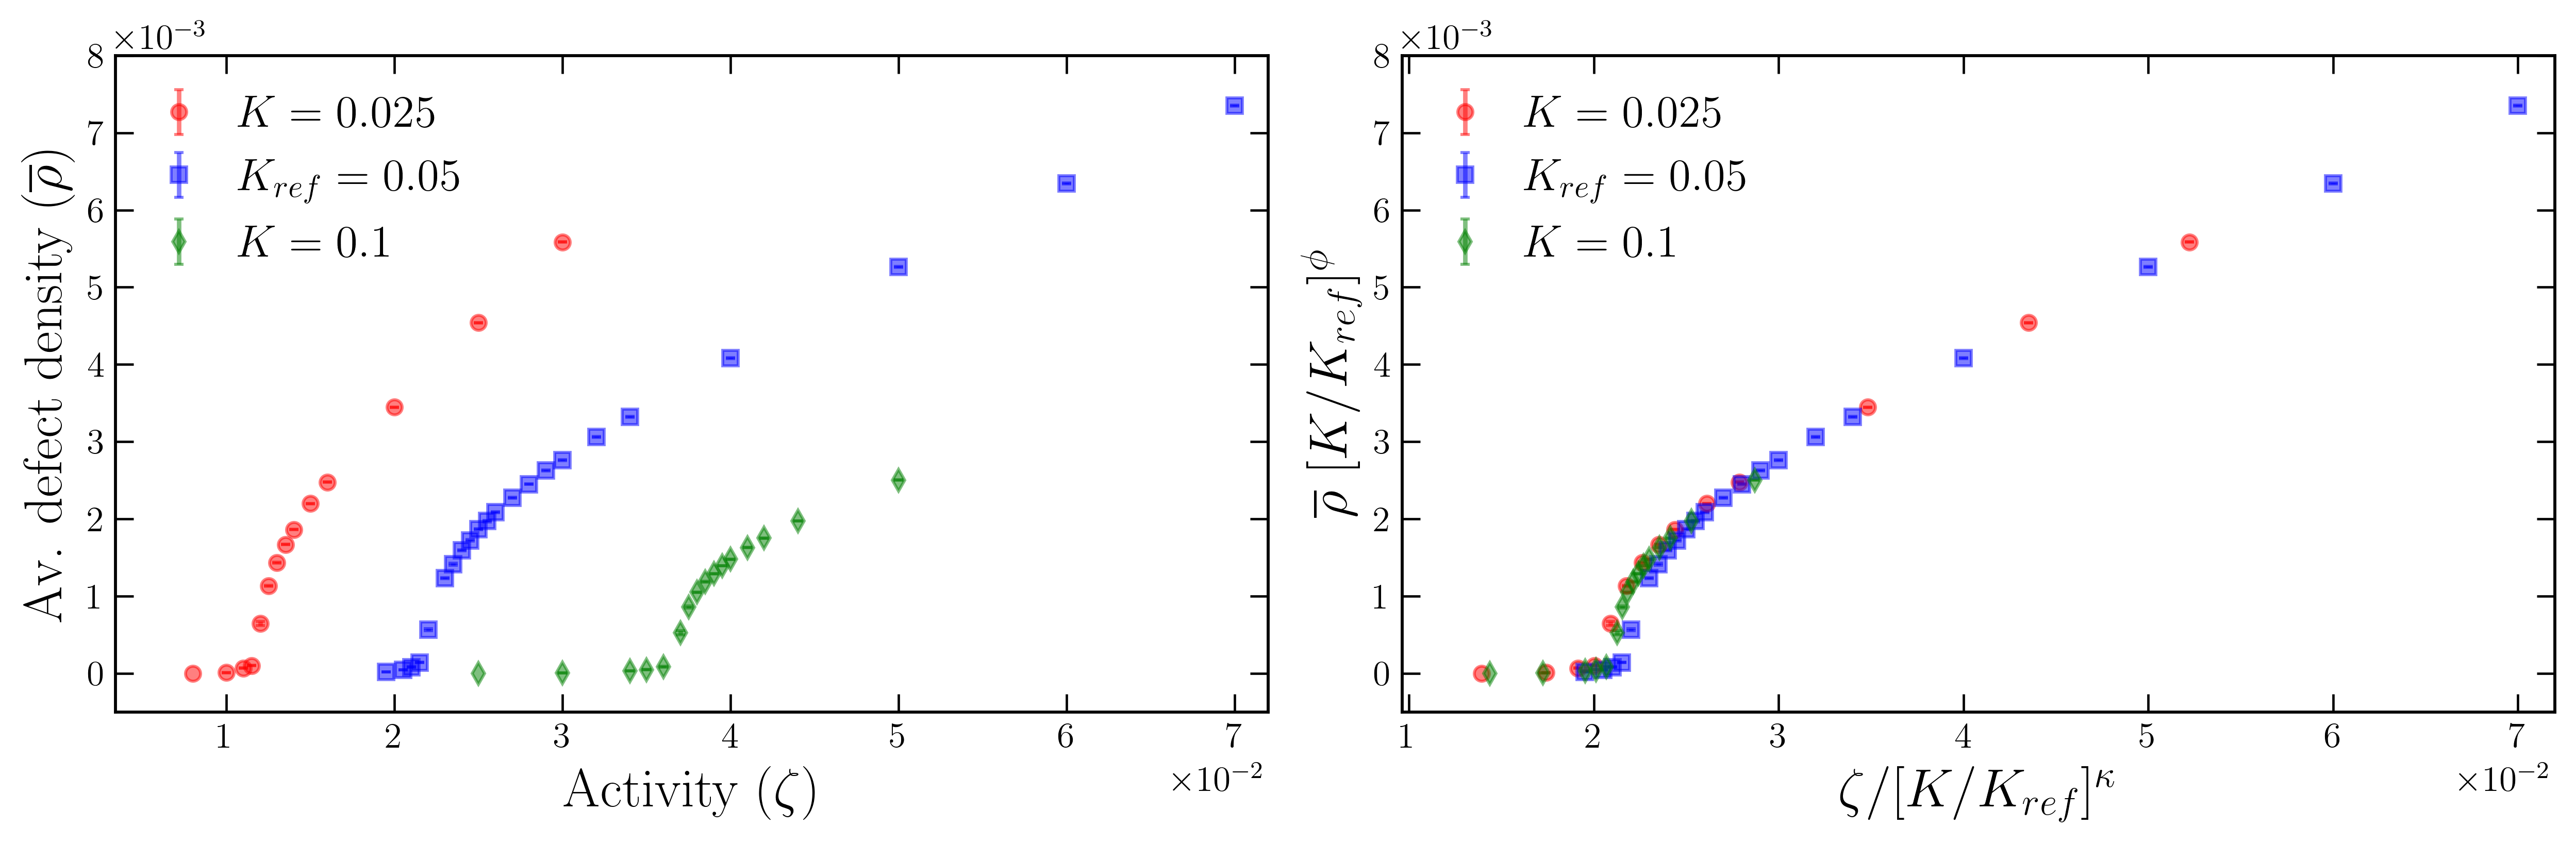

In [169]:
act_list_list = [ad.act_list[0], ad2.act_list_merged, ad.act_list[1]]
marker_list = ['ro', 'bs', 'gd']

fig2, ax2 = plt.subplots(ncols=2, figsize=(12,12/3))

K_list = [0.025, 0.05, 0.1]
K_rel_list = [.5, 1, 2]


## ASSUMPTION: Scaling relation of the form: rho(zeta,k) = k^ (-beta) * g (zeta/k^alpha),
## where g is a function of zeta/k^alpha, and beta is a scaling exponent.
## ie so that rho * k ^beta = g(zeta/k^alpha) and plotting rho * k^beta vs zeta/k^alpha should collapse graphs

av_defect_list = [ad.get_arrays_av(0)[-1], ad2.get_arrays_av(use_merged=True)[-1], ad.get_arrays_av(1)[-1]]

for i, label in enumerate(label_list):

    act_arr= np.array(act_list_list[i])

    alpha = .8
    beta = .3

    print(f'alpha: {alpha}, beta: {beta} ')

    #act_active = #np.sqrt(K_list[i])**1.6# / act_arr)
  #  scaling = 1/K_list[i] #/0.05 #1/ np.sqrt(act_arr/K_list[i])
    act_scaled = act_arr / K_rel_list[i]**alpha # np.sqrt(act_arr / K_list[i])

    #act_scaled = act_arr
    av_def = av_defect_list[i] / LL ** 2
    av_def[:,0] = av_def[:,0] * K_rel_list[i]**beta
    av_def[:,1] = av_def[:,1] * K_rel_list[i]**beta 

    label = r'$K_{ref} = 0.05$' if i == 1 else label
    ax2[0].errorbar(act_list_list[i], av_def[:,0], av_def[:,1], fmt = marker_list[i], label=label,
                elinewidth=1.5, capsize=1.5, capthick=1, markersize = 5, alpha=.5)
    ax2[1].errorbar(act_scaled, av_def[:,0], av_def[:,1], fmt = marker_list[i], label=label,
                elinewidth=1.5, capsize=1.5, capthick=1, markersize = 5, alpha=.5)

for j, ax in enumerate(ax2):
 #ax.set_xlabel(r'Activity ($\zeta$)' if j==0 else r'Rescaled Activity ($\zeta / \tilde k ^\kappa$)')
  ax.set_xlabel(r'Activity ($\zeta$)' if j==0 else r'$\zeta / [K / K_{ref}] ^\kappa$')
  ax.set_ylabel(r'Av. defect density ($\overline{\rho})$' if j==0 else r'$\overline{\rho} ~[K / K_{ref}] ^\phi$') 
  #ax.vlines(x=0.022, ymin = -1e-2, ymax=.6e-2, linestyle='--', color='k', lw = 1)
  #ax.hlines(y=0, xmin=0, xmax=.052, linestyle='-', color='k', lw = 1 )

  #ax.xaxis.set_minor_locator(ticker.MultipleLocator(2e-3))   
  #ax.yaxis.set_minor_locator(ticker.MultipleLocator(.5e-3))     
  #ax.set_xlim([0, 0.052])
  #ax.set_ylim(ymin=-.05e-2, ymax = .6e-2)
  ax.legend(loc='upper left', ncols=1)
  ax.set_xlim(xmax=.072)
  ax.set_ylim(ymax=8e-3);

fig2.savefig(os.path.join(save_path, f'density_comp.png'), bbox_inches='tight', dpi=420, pad_inches=0.1)

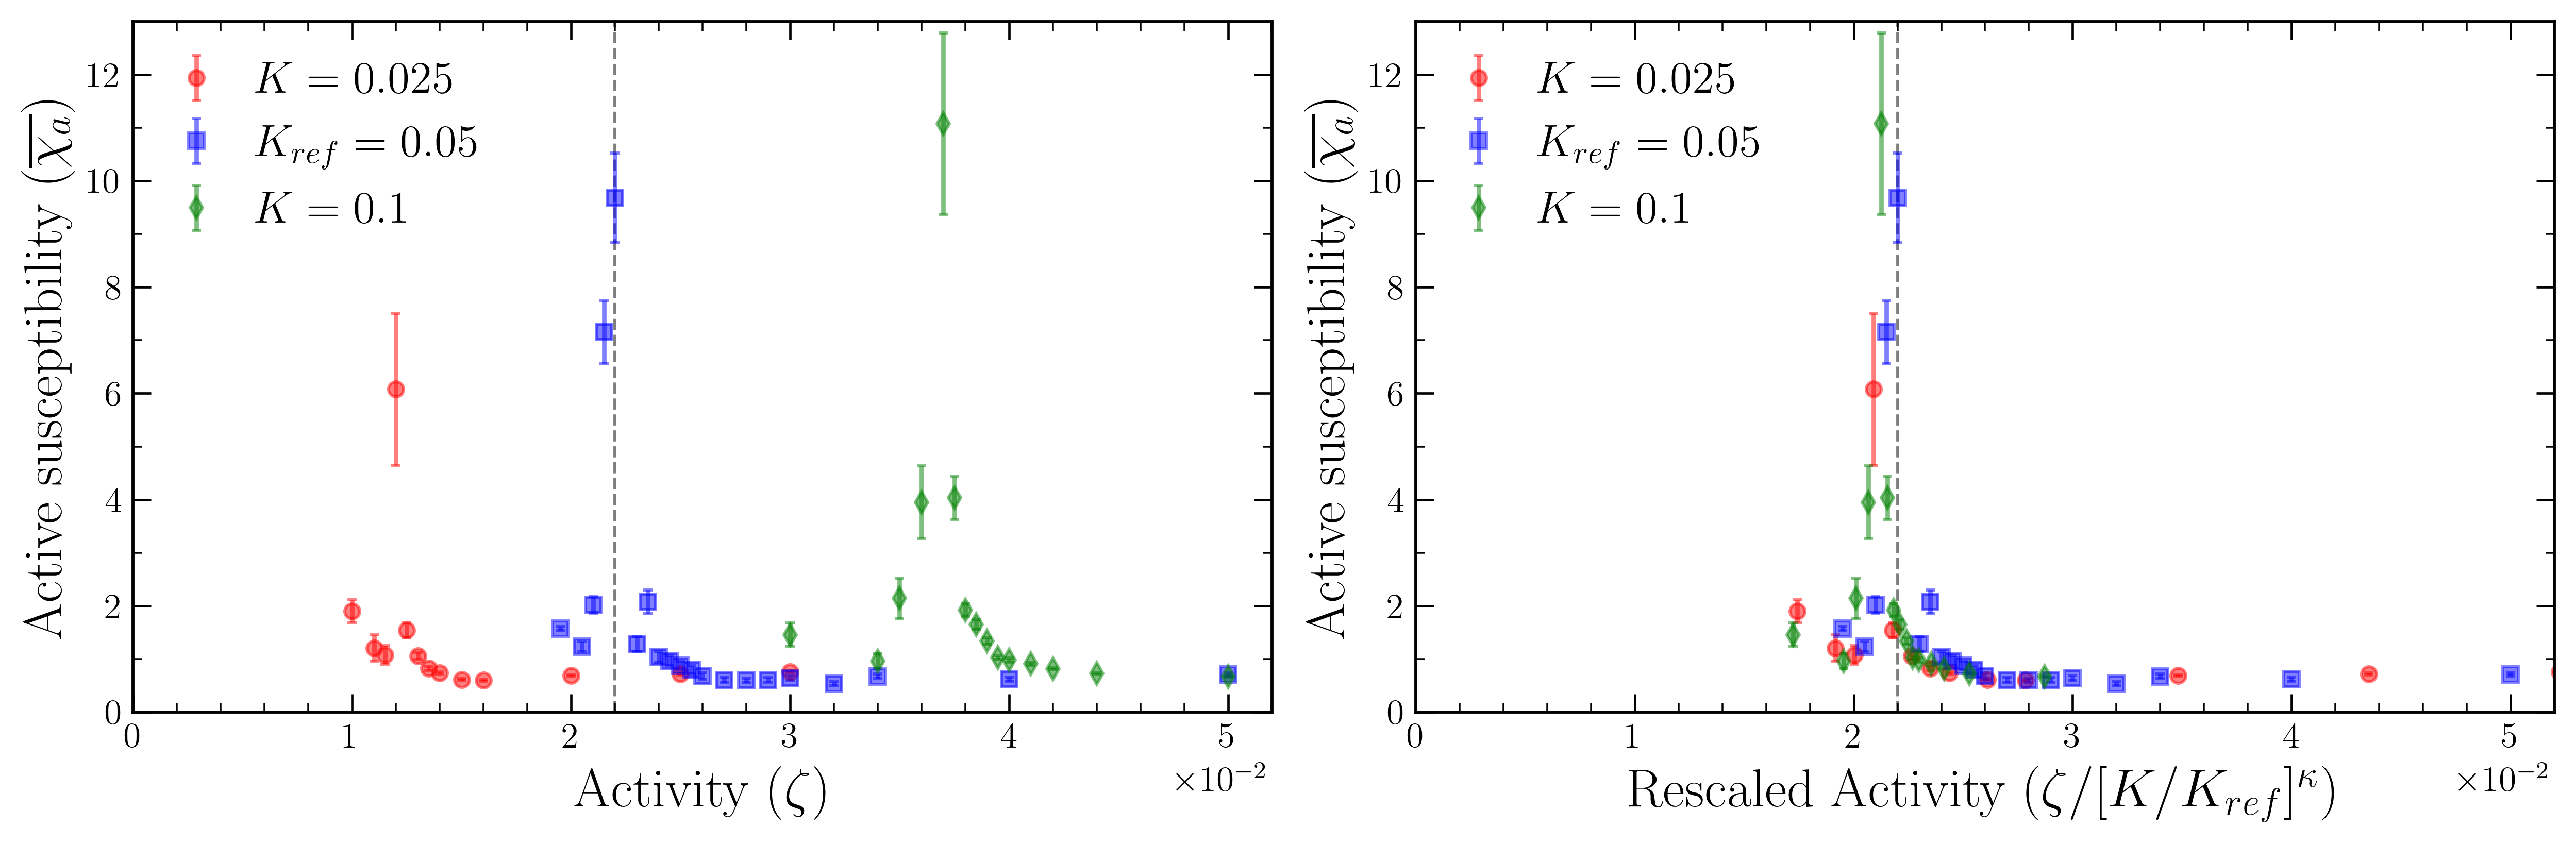

In [165]:
fig2, ax2 = plt.subplots(ncols=2, figsize=(12,12/3))
sus_list = [ad.get_susceptibility(0), ad2.get_susceptibility(use_merged=True), ad.get_susceptibility(1)]

K_rel_list = [.5, 1, 2]

alpha = .8


for i, label in enumerate(label_list):
    act_arr= np.array(act_list_list[i])
    act_scaled = act_arr / K_rel_list[i]**alpha
    sus = sus_list[i]
    label = r'$K_{ref} = 0.05$' if i == 1 else label
    ax2[0].errorbar(act_list_list[i], sus[:,0], sus[:,1], fmt = marker_list[i], label=label,
                elinewidth=1.5, capsize=1.5, capthick=1, markersize = 5, alpha=.5)
    ax2[1].errorbar(act_scaled, sus[:,0], sus[:,1], fmt = marker_list[i], label=label,
                elinewidth=1.5, capsize=1.5, capthick=1, markersize = 5, alpha=.5)
    
for j, ax in enumerate(ax2):
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(2e-3))   
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))     
    ax.set_xlim([0, 0.052])
    ax.set_ylim(ymin=0, ymax=13)
    ax.set_xlabel(r'Activity ($\zeta$)' if j==0 else r'Rescaled Activity ($\zeta / [K / K_{ref}] ^\kappa$)')
    ax.set_ylabel(r'Active susceptibility ($\overline{\chi_a})$')
    ax.vlines(x=0.022, ymin = -1.2, ymax=20, linestyle='--', color='k', lw = 1, alpha=.5, zorder=-10)
    #ax2.vlines(x=0.022, ymin = 4.15, ymax=8.5, linestyle='--', color='k', lw = 1, zorder=-10)
    ax.hlines(y=0, xmin=0, xmax=0.052, linestyle='-', color='k', lw = 1 )
    ax.legend(loc='upper left', ncols=1)
fig2.savefig(os.path.join(save_path, f'susceptibility_comp.png'), bbox_inches='tight', dpi=420, pad_inches=0.1)

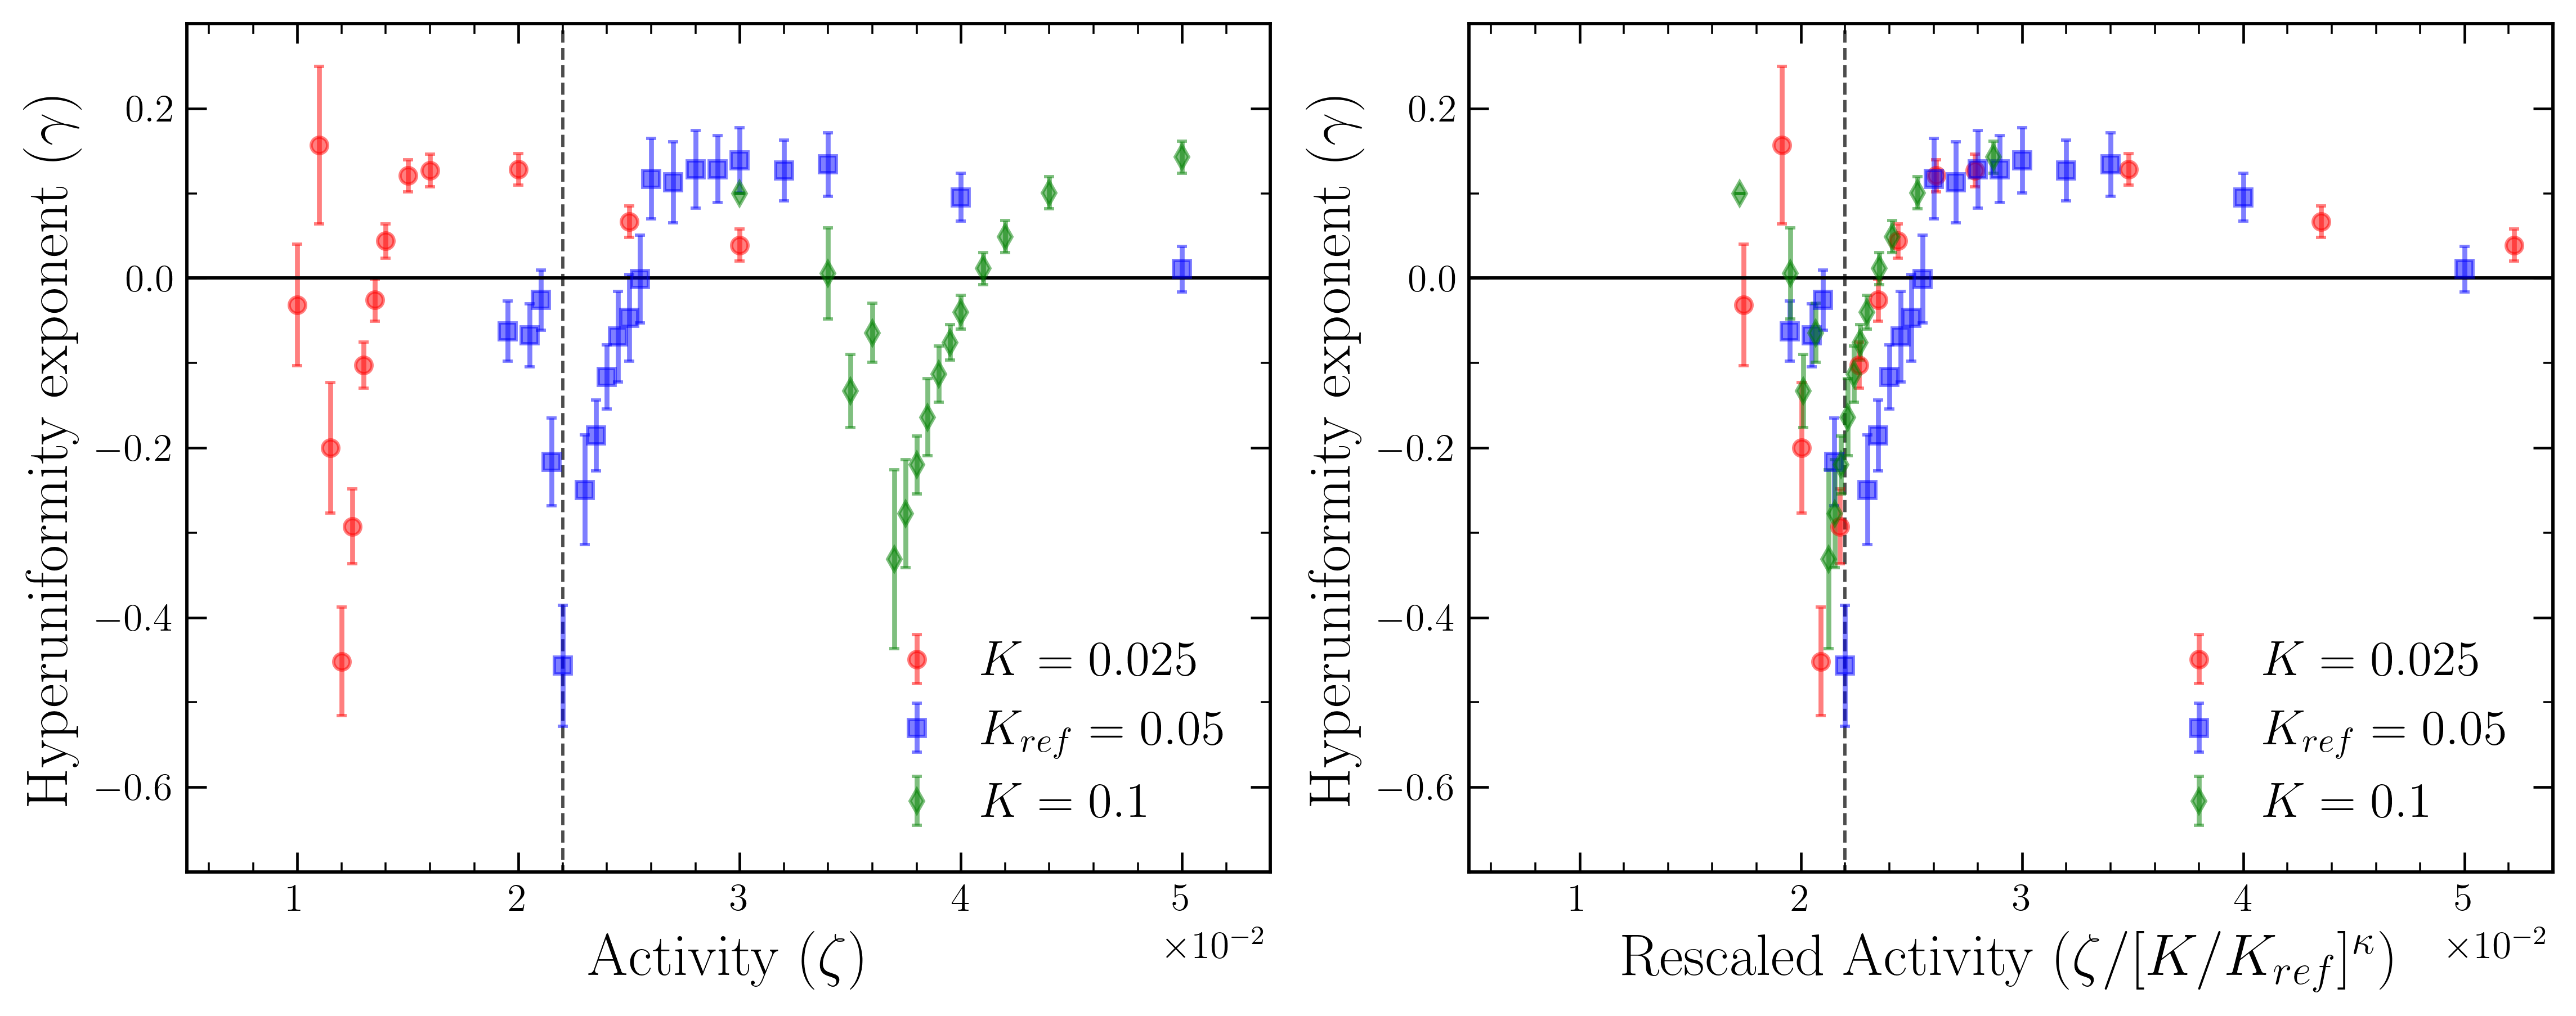

In [176]:
fig2, ax2 = plt.subplots(ncols=2, figsize=(11, 11/2.5))
fit_params_paths = [os.path.join(ad.output_paths[0], 'fit_params_sfac_time_av.npy'), 
                    os.path.join(ad2.output_merged, 'fit_params_sfac_time_av.npy'),
                    os.path.join(ad.output_paths[1], 'fit_params_sfac_time_av.npy')]

K_rel_list = [.5, 1, 2]
alpha = .8


for i, label in enumerate(label_list):
    fit_params = np.load(fit_params_paths[i])
    act_arr= np.array(act_list_list[i])
    act_scaled = act_arr / K_rel_list[i]**alpha

    label = r'$K_{ref} = 0.05$' if i == 1 else label

    ax2[0].errorbar(act_list_list[i], fit_params[:,0], yerr=fit_params[:,2], fmt = marker_list[i], label=label,
                elinewidth=1.5, capsize=1.5, capthick=1, markersize = 5, alpha=.5)
    ax2[1].errorbar(act_scaled, fit_params[:,0], yerr=fit_params[:,2], fmt = marker_list[i], label=label,
                elinewidth=1.5, capsize=1.5, capthick=1, markersize = 5, alpha=.5)

for j, ax3 in enumerate(ax2):
    ax3.xaxis.set_minor_locator(ticker.MultipleLocator(2e-3))   
    ax3.yaxis.set_minor_locator(ticker.MultipleLocator(.1))     
    ax3.set_xlim([0.005, 0.054])
    ax3.set_ylim(ymin=-.7, ymax=.3)
    ax3.set_xlabel(r'Activity ($\zeta$)' if j==0 else r'Rescaled Activity ($\zeta / [K / K_{ref}] ^\kappa$)')
    ax3.set_ylabel(r'Hyperuniformity exponent ($\gamma$)')
    ax3.vlines(x=0.022, ymin = -1.2, ymax=.56, linestyle='--', color='k', lw = 1, alpha=.7, zorder=-10)
    ax3.hlines(y=0, xmin=0, xmax=0.072, linestyle='-', color='k', lw = 1 )

    ax3.legend(loc='lower right', ncols=1)
fig2.savefig(os.path.join(save_path, 'alpha_comp.png'), dpi=420, bbox_inches='tight', pad_inches=0.1)

In [164]:
save_path

'data\\na512lk\\figs'